In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
import tensorflow as tf

import os
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import cv2

In [2]:
df_train = pd.read_csv('/mnt/sdb/DATASETS/diabetic_retinopathy/trainLabels.csv')
df_train.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


In [3]:
targets_series = pd.Series(df_train['level'])
one_hot = pd.get_dummies(targets_series, sparse = True)
one_hot_labels = np.asarray(one_hot)

In [4]:
im_size1 = 512
im_size2 = 512

x_train = []
y_train = []
x_test = []

New Data Size: 35126 Old Size: 750


array([[<AxesSubplot:title={'center':'level'}>,
        <AxesSubplot:title={'center':'eye'}>]], dtype=object)

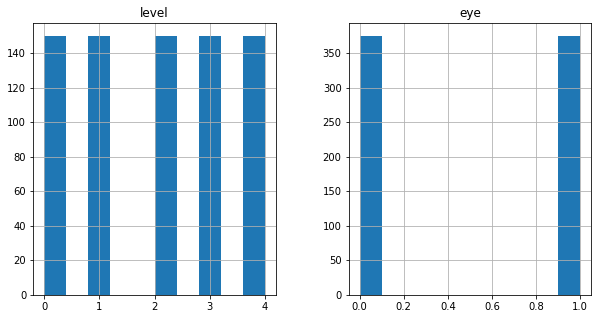

In [5]:
##Balancing dataset
df_train_eye = df_train
df_train_eye['eye'] = df_train['image'].map(lambda x: 1 if x.split('_')[-1]=='left' else 0)

raw_train_df = df_train_eye.groupby(['level', 'eye']).apply(lambda x: x.sample(75, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', df_train.shape[0], 'Old Size:', raw_train_df.shape[0])
raw_train_df[['level', 'eye']].hist(figsize = (10, 5))

In [6]:
del raw_train_df['eye']
raw_train_df.head()

,image,level
0,32442_right,0
1,38421_right,0
2,9257_right,0
3,20730_right,0
4,3089_right,0


In [7]:
i = 0 
for f, breed in tqdm(raw_train_df.values):

    if type(cv2.imread('/mnt/sdb/DATASETS/diabetic_retinopathy/train/{}.jpeg'.format(f)))==type(None):
        continue
    else:
        img = cv2.imread('/mnt/sdb/DATASETS/diabetic_retinopathy/train/{}.jpeg'.format(f))
        label = one_hot_labels[i]
        x_train.append(cv2.resize(img, (im_size1, im_size2)))
#         img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)#cv2.COLOR_BGR2HSV)
#         cv2.imshow('show',img)
#         cv2.waitKey(0)
#         x_train.append(cv2.resize(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), (im_size1, im_size2)))
#         cv2.imshow('show',img)
#         cv2.waitKey(0)
        y_train.append(label)
        i += 1

np.save('x_train2',x_train)
np.save('y_train2',y_train)
print('Done')

100%|██████████| 750/750 [01:53<00:00,  6.58it/s]


Done


In [8]:
x_train = np.load('x_train2.npy')
y_train = np.load('y_train2.npy')

In [9]:
np.save('/mnt/sdb/DATASETS/diabetic_retinopathy/x_train2',x_train)
np.save('/mnt/sdb/DATASETS/diabetic_retinopathy/y_train2',y_train)

In [10]:
y_train_raw = np.array(y_train, np.uint8)
x_train_raw = np.array(x_train, np.float32) / 255.

In [11]:
print(x_train_raw.shape)
print(y_train_raw.shape)


(750, 512, 512, 3)
(750, 5)


In [12]:
X_train, X_valid, train_labels, valid_labels = train_test_split(x_train_raw, y_train_raw, test_size=0.6, random_state=1)

In [13]:
train_labels.shape

(300, 5)

In [14]:
training_images = X_train
testing_images = X_valid

from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Create an ImageDataGenerator and do Image Augmentation
train_datagen = ImageDataGenerator(
    zoom_range=0.2,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(
)
    
# Keep These
print(training_images.shape)
print(testing_images.shape)
# print(X_train.shape)
# print(X_valid.shape)

(300, 512, 512, 3)
(450, 512, 512, 3)


In [15]:
from keras.applications.vgg16 import VGG16 as PTModel
from keras.applications.inception_resnet_v2 import InceptionResNetV2 as PTModel
from keras.applications.inception_v3 import InceptionV3 as PTModel
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from keras.models import Model


in_lay = Input((512, 512, 3))
base_pretrained_model = PTModel(input_shape =  (512, 512, 3), include_top = False, weights = None)
base_pretrained_model.trainable = False
pt_depth = (512, 512, 3)
pt_features = base_pretrained_model(in_lay)
from keras.layers import BatchNormalization
bn_features = BatchNormalization()(pt_features)


attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(Dropout(0.5)(bn_features))
attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(8, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(1, kernel_size = (1,1), padding = 'valid', activation = 'sigmoid')(attn_layer)


mask_features = multiply([attn_layer, bn_features])
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attn_layer)


# to account for missing values from the attention model
gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
gap_dr = Dropout(0.25)(gap)
dr_steps = Dropout(0.25)(Dense(128, activation = 'relu')(gap_dr))
out_layer = Dense(5, activation = 'softmax')(dr_steps)
retina_model = Model(inputs = [in_lay], outputs = [out_layer])



from keras.metrics import top_k_categorical_accuracy

def top_2_accuracy(in_gt, in_pred):
    return top_k_categorical_accuracy(in_gt, in_pred, k=2)

retina_model.compile(optimizer = 'SGD', loss = 'categorical_crossentropy',
                           metrics = ['categorical_accuracy', top_2_accuracy])
retina_model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
inception_v3 (Functional)       (None, 14, 14, 2048) 21802784    input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 14, 14, 2048) 8192        inception_v3[0][0]               
__________________________________________________________________________________________________
dropout (Dropout)               (None, 14, 14, 2048) 0           batch_normalization_94[0][0]     
______________________________________________________________________________________________

In [16]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('retina')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.000001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=10) 
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [17]:
# Configure generators
train_gen = train_datagen.flow(
    training_images,
    train_labels,
    batch_size=5
)

val_gen = validation_datagen.flow(
    testing_images,
    valid_labels,
    batch_size=5
)

In [18]:
!rm -rf ~/.keras 

In [19]:
history = retina_model.fit(
    train_gen,
    epochs=10,
    callbacks = callbacks_list,
    validation_data=val_gen
)

retina_model.evaluate(testing_images, valid_labels)

Epoch 1/10
60/60 [==============================] - 47s 753ms/step - loss: 1.4618 - categorical_accuracy: 0.6913 - top_2_accuracy: 0.8053 - val_loss: 1.0500 - val_categorical_accuracy: 0.7600 - val_top_2_accuracy: 0.8978

Epoch 00001: val_loss improved from inf to 1.05003, saving model to retina_weights.best.hdf5
Epoch 2/10
60/60 [==============================] - 44s 739ms/step - loss: 0.9986 - categorical_accuracy: 0.7555 - top_2_accuracy: 0.8999 - val_loss: 0.8677 - val_categorical_accuracy: 0.7600 - val_top_2_accuracy: 0.8978

Epoch 00002: val_loss improved from 1.05003 to 0.86775, saving model to retina_weights.best.hdf5
Epoch 3/10
60/60 [==============================] - 44s 741ms/step - loss: 0.8454 - categorical_accuracy: 0.7785 - top_2_accuracy: 0.8922 - val_loss: 0.8367 - val_categorical_accuracy: 0.7600 - val_top_2_accuracy: 0.8978

Epoch 00003: val_loss improved from 0.86775 to 0.83674, saving model to retina_weights.best.hdf5
Epoch 4/10
60/60 [=============================

[0.8200329542160034, 0.7599999904632568, 0.897777795791626]

acc :  [0.7400000095367432, 0.753333330154419, 0.753333330154419, 0.753333330154419, 0.753333330154419, 0.753333330154419, 0.753333330154419, 0.753333330154419, 0.753333330154419, 0.753333330154419]


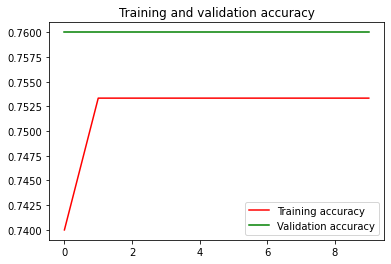

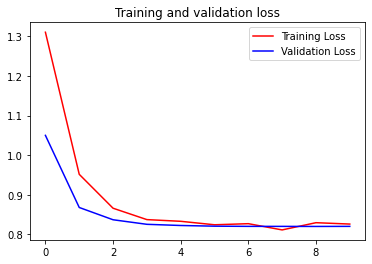

Top Accuracy =  90.3333306312561


In [21]:
import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
print("acc : ",acc)
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
top_2_acc = history.history['top_2_accuracy']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

print("Top Accuracy = ",max(top_2_acc)*100)

In [24]:
retina_model.load_weights(weight_path)
retina_model.save('/mnt/sdb/DATASETS/diabetic_retinopathy/rgb_model')

INFO:tensorflow:Assets written to: /mnt/sdb/DATASETS/diabetic_retinopathy/rgb_model/assets
